Proyect Description

Beta Bank is experiencing a gradual decline in customers. 

The objective is to study the customers behavioral pattern to predict which clients will leave the bank service soon. 

For that a ML model with maximized F1 score >59% will be made. 

In [106]:
#New installations 
#!pip install imblearn
#!pip install xgboost


#Library Setup
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from  sklearn.model_selection import train_test_split, GridSearchCV
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import xgboost as xgb
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

#libraries that can be used for influencing class weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

In [79]:
#Data importing
churned_data = pd.read_csv("Churn.csv")
print(churned_data.shape)
print(churned_data.columns)


(10000, 14)
Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


In [80]:
#Exploratory Data Analysis
churned_data.info()
#Exited, IsActiveMember. Review of datatype: they are booleans in integer. 1 or 0. 
print(churned_data["Exited"].head())
print(churned_data["IsActiveMember"].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64
0    1
1    1
2    0
3    0
4   

The data has categorical columns that may need to be numerically encoded to be managed in a Machine Learning model. 

Columns: Surname, Geography, Gender.

Tenure column has nan so an imputing action would be of help. 

Status of the data

In [81]:
#Imputting tenure with the most relevantly fitted registries, advanced imputing. KNN algorithm of imputing. 
#Just Tenure column needs imputting and categorical columns need encoding. 
knn_imputer = KNNImputer(n_neighbors=3)
churned_data['Tenure'] = knn_imputer.fit_transform(churned_data[['Tenure']])

#making changes to a function so that it can be applied to several columns: 
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Nothing needs to be fit here, since LabelEncoder does the job directly.

    def transform(self, X):
        # Apply LabelEncoder to each column
        for column in X.columns:
            le = LabelEncoder()
            X[column] = le.fit_transform(X[column])
        return X

#Split columns into categorical and numerical 
categorical_columns = churned_data.select_dtypes(include=['object']).columns #This ones need encoding
numerical_columns = churned_data.select_dtypes(exclude=['object']).columns #Only tenure needed imputting but nothing extra happens by processing the columns if there are no Nan values. 
numerical_columns = numerical_columns.drop(["Exited"])
#Split target so that the standardscaler does not affect it 
target = churned_data['Exited']
features = churned_data.drop(columns=['Exited'])

#Preprocessing pipelines
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())            
])

#Encoding of categorical data 
categorical_pipeline = Pipeline([
    ('encoder', LabelEncoderTransformer())                            # Label encoding
])
#preprocessor pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),  
        ('cat', categorical_pipeline, categorical_columns)  
    ])
#Applying my preprocessor of data to conclude normalization and encoding
churned_data_encoded = preprocessor.fit_transform(features)
churned_data_encoded = pd.DataFrame(churned_data_encoded, columns=numerical_columns.tolist() + categorical_columns.tolist())
churned_data_encoded.info()


#Data splitting 
#60% train, 40% test and validation. 20% each. 
train, test = train_test_split(churned_data_encoded, test_size= 0.4, random_state=12345)
valid, test = train_test_split(test, test_size= 0.5, random_state=12345)
#Testing the size of the samples to match the logic of the split
print("Train data size: ", train.shape)
print("Test data size: ", test.shape)
print("Validation data size: ", valid.shape)
print("Correct Data splitting.")

#Splitting of my datasets (train, test, valid) into target and features. The variable to be modeled is Exited. 
train_target = target.loc[train.index]
test_target = target.loc[test.index]
valid_target = target.loc[valid.index]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  float64
 1   CustomerId       10000 non-null  float64
 2   CreditScore      10000 non-null  float64
 3   Age              10000 non-null  float64
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  float64
 7   HasCrCard        10000 non-null  float64
 8   IsActiveMember   10000 non-null  float64
 9   EstimatedSalary  10000 non-null  float64
 10  Surname          10000 non-null  float64
 11  Geography        10000 non-null  float64
 12  Gender           10000 non-null  float64
dtypes: float64(13)
memory usage: 1015.8 KB
Train data size:  (6000, 13)
Test data size:  (2000, 13)
Validation data size:  (2000, 13)
Correct Data splitting.


In [82]:
#Study the model previous to class balancing by under or oversampling techniques. So basically data as is which is dominated by clients that have not yet churned while we want to mainly study the characteristics of churned clients. 
rf_model = RandomForestClassifier(
    n_estimators=100,              # Number of trees
    max_depth=6,                   # Depth of each tree
    random_state=12345,               # For reproducibility
    n_jobs=-1                      # Use all cores to speed up computation
)

# Train the model
rf_model.fit(train, train_target)

# Make predictions on the validation data
valid_predictions = rf_model.predict(valid)

# Evaluate F1 Score
f1 = f1_score(valid_target, valid_predictions)
print(f"F1 Score: {f1}")
print("Without balancing the classes the model performs poorly in terms of making many false positives (clients that will churn when they really wont) and \nfalse negatives (predicting clients which will churn or have churned while they are still regular clients).")


F1 Score: 0.4906303236797274
Without balancing the classes the model performs poorly in terms of making many false positives (clients that will churn when they really wont) and 
false negatives (predicting clients which will churn or have churned while they are still regular clients).


Exited
0    0.800667
1    0.199333
Name: proportion, dtype: float64


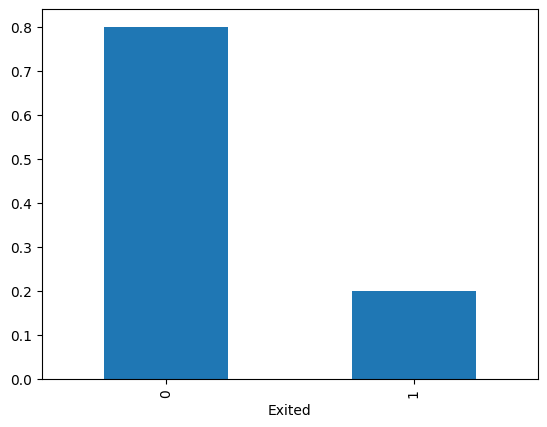

The data consists of 80% non churn registries and roughly 20% clients that have churned.


In [83]:
#Class weight exploration
#In a model having too much of one of the values can be detrimental for the predictions. Asses 0 and 1 representation to get close to 0.5 or at least a .7 to 0.3 with undersample and oversampling techniques. 
class_frequency = train_target.value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind= "bar")
plt.show()
print("The data consists of 80% non churn registries and roughly 20% clients that have churned.")
#80% have not exited yet of the bank. The classes of churned and non churned are not balanced so bringing them to a ratio close to 50% each would help for the purpose of training the model and select a balanced weight. If not the model may generalize as having a bias towards predicting the class that repeats the most. 

In [84]:
#To improve the prediction of churning it is relevant to have a close to 50% balance of each datatypes and in this particular model we could even think about 
#magnifying further the data of churning clients which are the ones we want to study more.

#In this section regular undersample and oversample techniques are performed. Undersampling by simple random discarding of the most represented value (in this case 0)
#can help balance the ratio between classes at the risk of loosing relevant data.

#Undersampling can be performed by either logic or using the RandomUnderSampler function. 
#If desired (oversampling) repeating the less represented value which is 1 could also work.


#concatenation of values in a new dataframe.  
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]) #here it is stating to just select a fracting of the most represented value which is 0. This is a manual function made with logic. 
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    train, train_target, 0.25 #As the 0s where 80% of the sample and the 1 only 20% i just took a random 1/4 of the 0s data as my sample and joined it to the whole less represented 0 values. 
)

print(features_downsampled.shape)
print(target_downsampled.shape) 
#With his method 2600 values where lost out of 6000. How will this impact the model? It is interesting to check with my non balanced value data as a contrast. 
print(target_downsampled.value_counts())
print("5 records of difference, samples are about 50% 0's and 50% 1's. Nonetheless, a significant portion of data got lost I will look to resample more assertively by an alternative method but first test my prediction assertiveness by training an ML model.")

#Alternatives to reduce more represented value:  cluster_centroids for representativity instead of random discarding or RandomUnderSampler for less code. 


(2397, 13)
(2397,)
Exited
0    1201
1    1196
Name: count, dtype: int64
5 records of difference, samples are about 50% 0's and 50% 1's. Nonetheless, a significant portion of data got lost I will look to resample more assertively by an alternative method but first test my prediction assertiveness by training an ML model.


In [85]:
#Study the model with regular under sampling
rf_model = RandomForestClassifier(
    n_estimators=100,              # Number of trees
    max_depth=6,                   # Depth of each tree
    random_state=12345,
    class_weight="balanced", #Adding this argument really did not improve f1score at all probably due to classes being really close to 50%. 
    n_jobs=-1                      # Use all cores to speed up computation
)

# Train the model
rf_model.fit(features_downsampled, target_downsampled)

# Make predictions on the validation data
valid_predictions = rf_model.predict(valid)

# Evaluate F1 Score
f1 = f1_score(valid_target, valid_predictions)
print(f"F1 Score: {f1}")
print("The model improved significantly to a f1 score of .58 we seek a prediction value with veracity given by assertively defining the classes (true false and true positives while really true).")


F1 Score: 0.584817244611059
The model improved significantly to a f1 score of .58 we seek a prediction value with veracity given by assertively defining the classes (true false and true positives while really true).


In [86]:
#Aiming to lose less data, cluster centroids a representative undersampling technique which gets the most central data of the different patters in the sample in a fraction related to the amount of the minority was used.
#Using cluster centroids with the argument sampling_strategy at 0.4 the majority class gets reduced to 4o% of the minority amount of data but is representative of the patterns of non churned and as it got reduced to being the minority class
#using smote then generates synthethic data points that can rebalance the amount to even the same amount as the minority class if given a sampling strategy of 1. 
#Smote of 90% of the non churned amount of registries. 
undersample = ClusterCentroids(sampling_strategy=0.4, random_state=12345) #Cluster centroids favors the study of the minority class while maintaining as much representativity of churning as possible. 
features_train_under, target_train_under = undersample.fit_resample(train, train_target)
smote = SMOTE(sampling_strategy=1, random_state=12345) #Smote generates synthetic data points of the minority class that now is non churned as it got reduced in the cluster centroids step. 
features_balanced_train, target_balanced_train = smote.fit_resample(features_train_under, target_train_under)
print(features_balanced_train.shape)
print(target_balanced_train.shape)
print(target_balanced_train.value_counts())
print("Completely balanced data classes. 50% churned, 50% non churned.")
print("Using cluster centroids and smote the representativity of my data is maximized while also being balanced.")


(5980, 13)
(5980,)
Exited
0    2990
1    2990
Name: count, dtype: int64
Completely balanced data classes. 50% churned, 50% non churned.
Using cluster centroids and smote the representativity of my data is maximized while also being balanced.


In [ ]:
rf2_model = RandomForestClassifier(
    n_estimators=100,              # Number of trees
    max_depth=8,                   # Depth of each tree
    random_state=12345,               # For reproducibility
    class_weight="balanced",  
    n_jobs=-1                      # Use all cores to speed up computation
)

# Train the model
rf2_model.fit(features_balanced_train, target_balanced_train)

# Make predictions on the validation data
valid_predictions = rf2_model.predict(valid)

# Evaluate F1 Score, recall and precision prior to maximizing f1 score.
precision = precision_score(valid_target, valid_predictions)
print(f"The model is {precision*100}% appropriate at detecting positive cases that are true positives.")
recall = recall_score(valid_target, valid_predictions)
print(f"The model detects {recall*100}% of all positive cases. This metric should be high given the scope of predicting posibility of churning.")
f1 = f1_score(valid_target, valid_predictions)
print(f"F1 Score: {f1}")
print("The model is able to predict true false and true positives with about 59% assertiveness at regular threshold 0.5.\nThe model can be adjusted to augment the probability of catching likely to churn reducing the threshold to 0.4% instead of regular 50% chance for each. It is a way to prioritize predicting clients that may churn.")
print(" Now we can test it with the test data. \nAlso relevant to note the model is being tested in predicted with untreated or unmodified data of the valid and test portions made by splitting my initial data.")

The model is 54.563894523326574% appropriate at detecting positive cases that are true positives.
The model detects 64.35406698564593% of all positive cases. This metric should be high given the scope of predicting posibility of churning.
F1 Score: 0.5905598243688255
The model is able to predict true false and true positives with about 59% assertiveness at regular threshold 0.5.
The model can be adjusted to augment the probability of catching likely to churn reducing the threshold to 0.4% instead of regular 50% chance for each. It is a way to prioritize predicting clients that may churn.
 Now we can test it with the test data. 
Also relevant to note the model is being tested in predicted with untreated or unmodified data of the valid and test portions made by splitting my initial data.


In [113]:
#Setting an adjustment of reducing the threshold to catch more customers that could churn
max_recall_proba = rf2_model.predict_proba(valid)[:, 1]
threshold = 0.4 #lowering the threshold to facilitate catching more customers that could churn. 
max_recall_predictions = (max_recall_proba >= threshold).astype(int) #if the probability of churning is greater than threshold for now 40% it will be classified as churn. 
recall = recall_score(valid_target, max_recall_predictions)
print(f"Improved recall by lowering threshold to {threshold}: {recall}") 
print("By lowering the threshold incentives could be given to approximately 77% of clients that will likely churn.")
print("The threshold can be further reduced to reach more clients according to the decision of the executive chief officer regarding incentives investment.")
new_f1 = f1_score(valid_target, max_recall_predictions)
print(f"Implementing the strategy to make the model more sensitive to possibility of churning, of great relevance to the scope of the project, would reduce the f1 metric by 2% \ndue to an imbalance of recall and precision failing the initial threshold stated to be 59% but achieving better real results.")

Improved recall by lowering threshold to 0.4: 0.7751196172248804
By lowering the threshold incentives could be given to approximately 77% of clients that will likely churn.
The threshold can be further reduced to reach more clients according to the decision of the executive chief officer regarding incentives investment.
Implementing the strategy to make the model more sensitive to possibility of churning, of great relevance to the scope of the project, would reduce the f1 metric by 2% 
due to an imbalance of recall and precision failing the initial threshold stated to be 59% but achieving better real results.


ROC AUC: 0.7509738747512386


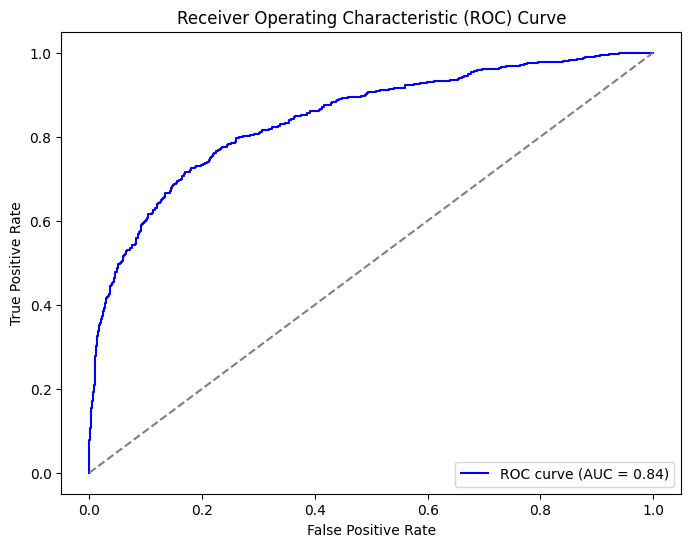

The function roc_auc_score has the best mathematical performance due to technicism such as a broader threshold integration and states that the model correctly distinguishes between classes in 75% of the cases 
but at some thresholds it may even have a predictive ability of about 84%. This serves to state the model as a moderate to fairly strong predictive performance model to detect churning. 
If the aim is to catch more clients the threshold can be further reduced at the expense of applying the incentives to more clients and getting a lower ROC value as the model will not be as precise in distinguishing classes but rather good at pointing towards clients that could churn even if some were not as close to churning.


In [114]:
# Evaluate ROC AUC of the validation dataset. 
roc_auc = roc_auc_score(valid_target, valid_predictions)
print(f"ROC AUC: {roc_auc}")

# Plot ROC Curve
valid_predict = rf_model.predict_proba(valid)[:, 1]
fpr, tpr, thresholds = roc_curve(valid_target, valid_predict) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print("The function roc_auc_score has the best mathematical performance due to technicism such as a broader threshold integration and states that the model correctly distinguishes between classes in 75% of the cases \nbut at some thresholds it may even have a predictive ability of about 84%. This serves to state the model as a moderate to fairly strong predictive performance model to detect churning. \nIf the aim is to catch more clients the threshold can be further reduced at the expense of applying the incentives to more clients and getting a lower ROC value as the model will not be as precise in distinguishing classes but rather good at pointing towards clients that could churn even if some were not as close to churning.")

In [115]:
#Testing the model with a new fraction of the initial data: test data. 
test_predictions = rf2_model.predict(test)

# Evaluate F1 Score
f1 = f1_score(test_target, test_predictions)
print(f"F1 Score: {f1}")
print("The model is able to predict true false and true positives with an extremely consistency of the same f1 score of 59% assertiveness.")

F1 Score: 0.5906623235613464
The model is able to predict true false and true positives with an extremely consistency of the same f1 score of 59% assertiveness.


ROC AUC: 0.843664370096601


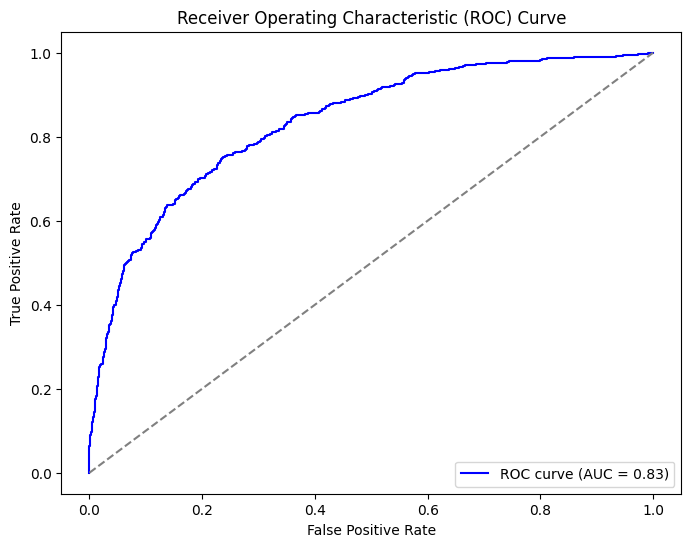

A better performance was obtained in assertiveness distinguishing between true positives in data of about 83 to 84% performing as a strong model at detecting possibility of churning which is the main scope of the model in this project.


In [116]:
#Reviewing cosistency of ROC-AUC with the test data. 
print(f"ROC AUC: {roc_auc}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(test_target, rf_model.predict_proba(test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print("A better performance was obtained in assertiveness distinguishing between true positives in data of about 83 to 84% performing as a strong model at detecting possibility of churning which is the main scope of the model in this project.")

Conclusions

A model was trained under a range of sampling techniques reaching a predictive ability of detecting true positives of about 75%-84% assertiveness. 

Initially the model has an f1 score of about 60% which is a metric of balance between precision, the rate of identifying true positives out of all positive predictions made by the model. This metric is related to the model mistakenly making false positives which is not as relevant for the scope of the project. 

It is of the best interest of the entreprise to maximize recall which would diminish f1 score and area under the curve metrics as it would reduce precision by making more positive predictions for the purpose of predicting clients close to churning and reduce the distinguishing ability between classes of the model at the advantage of being more sensitive to the possibility of churning. 

My advise would be to reduce the threshold required to predict positive as needed according to the reach and investment desired by the according decision making people. 

As of now the model has precision in distinguishing classes and metrics acceptable for the task f1score consistent and greater than 59% and ROC from 75%-84% making it a strong performer in detecting churning of data. Still as mentioned if the model does not function as measured on data of clients that have not yet churned the threshold can be manipulated to prioritize the detection of the clients most related to the patterns of clients that have churned.